# Convex optimization demo

1. pip install cvxpy
2. Get a MOSEK academic license (free): https://www.mosek.com/products/academic-licenses/


##### Basic CVX rules/tips:
1. The objective function must be the sum of convex functions. You cannot add a convex and a concave function.
2. You cannot multiply variables
3. When using constraints, it is most robust to use >= and <=, not ==

##### Additional functions you can use:
https://www.cvxpy.org/tutorial/functions/index.html

In [883]:
import numpy as np
import matplotlib.pyplot as plt

In [884]:
import cvxpy

# Simulate a linear system

In [885]:
Atrue = np.matrix([[1, 0.1, 0.03],
              [-0.1, 0.98, -0.1],
              [0,    0, 1]])

In [886]:
Xtrue = np.matrix([[0], [0.5], [0.5]])

iterations = 400
for i in range(iterations):
    xnew = Atrue*Xtrue[:, -1]
    Xtrue = np.hstack((Xtrue, xnew))

# Make snapshots with noise

In [887]:
Xn = Xtrue + np.matrix([np.random.normal(0, 0.02, iterations+1)]*3)

X1 = Xn[:,0:-1] 
X2 = Xn[:,1:] 

Text(0,0.5,'State value')

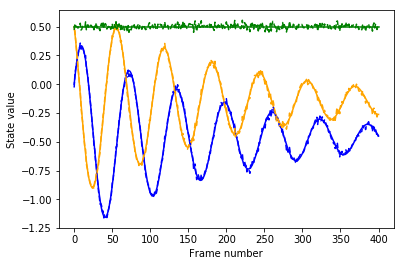

In [888]:
plt.plot(Xtrue[0,:].T, color='blue', linestyle='-')
plt.plot(Xtrue[1,:].T, color='orange', linestyle='-')
plt.plot(Xtrue[2,:].T, color='green', linestyle='-')

plt.plot(Xn[0,:].T, color='blue', linestyle='--')
plt.plot(Xn[1,:].T, color='orange', linestyle='--')
plt.plot(Xn[2,:].T, color='green', linestyle='--')

plt.xlabel('Frame number')
plt.ylabel('State value')

# Naive reconstruction through pseudo inverse

In [889]:
A_pinv = X2*np.linalg.pinv(X1)

In [890]:
A_pinv

matrix([[ 0.99130606,  0.09242159,  0.01800665],
        [-0.10766104,  0.97463765, -0.10941916],
        [-0.00831029, -0.0067553 ,  0.98896278]])

In [891]:
# reconstruct timeseries

X = X1[:,0]

iterations = 400
for i in range(iterations):
    xnew = A_pinv*X[:, -1]
    X = np.hstack((X, xnew))

Text(0,0.5,'State value')

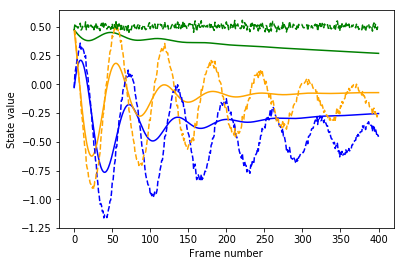

In [892]:
plt.plot(X[0,:].T, color='blue', linestyle='-')
plt.plot(X[1,:].T, color='orange', linestyle='-')
plt.plot(X[2,:].T, color='green', linestyle='-')

plt.plot(Xn[0,:].T, color='blue', linestyle='--')
plt.plot(Xn[1,:].T, color='orange', linestyle='--')
plt.plot(Xn[2,:].T, color='green', linestyle='--')

plt.xlabel('Frame number')
plt.ylabel('State value')

# Naive reconstruction using CVX 

(Essentially the same as the pseudo inverse)

In [893]:
# Set up the variables
A = cvxpy.Variable((X.shape[0], X.shape[0]))

# Define the objective function
L1 = cvxpy.sum_squares(X2 - (A@X1)) # X2 = A X1, this constraint is "the data"
obj = cvxpy.Minimize(L1) 

# Set up problem
prob = cvxpy.Problem(obj)

# Solve problem
prob.solve(solver='MOSEK')

# Pull out A
A_cvx_naive = np.matrix(A.value)

In [894]:
A_cvx_naive

matrix([[ 0.99130606,  0.09242159,  0.01800665],
        [-0.10766104,  0.97463764, -0.10941916],
        [-0.00831029, -0.0067553 ,  0.98896277]])

In [895]:
# reconstruct timeseries

X = X1[:,0]

iterations = 400
for i in range(iterations):
    xnew = A_cvx_naive*X[:, -1]
    X = np.hstack((X, xnew))

Text(0,0.5,'State value')

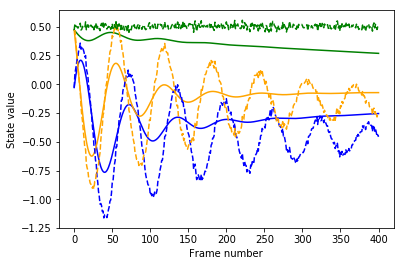

In [896]:
plt.plot(X[0,:].T, color='blue', linestyle='-')
plt.plot(X[1,:].T, color='orange', linestyle='-')
plt.plot(X[2,:].T, color='green', linestyle='-')

plt.plot(Xn[0,:].T, color='blue', linestyle='--')
plt.plot(Xn[1,:].T, color='orange', linestyle='--')
plt.plot(Xn[2,:].T, color='green', linestyle='--')

plt.xlabel('Frame number')
plt.ylabel('State value')

# First informed reconstruction of A

Suppose we know the last row.

In [897]:
# Set up the variables
A = cvxpy.Variable((X.shape[0], X.shape[0]))

# Define the objective function
L1 = cvxpy.sum_squares(X2 - (A@X1)) # X2 = A X1, this constraint is "the data"
obj = cvxpy.Minimize(L1) 

In [898]:
# Create some constraints: for each element that is known, constrain the value by some epsilon

A_known = np.matrix([[np.nan, np.nan, np.nan],
                     [np.nan, np.nan, np.nan],
                     [0, 0, 1]])

epsilon = 1e-8
constraints = []
if A_known is not None:
    for i in range(A_known.shape[0]):
        for j in range(A_known.shape[1]):
            if not np.isnan(A_known[i,j]):
                constraint_lo = A[i,j] >= A_known[i,j]-epsilon
                constraint_hi = A[i,j] <= A_known[i,j]+epsilon 
                constraints.extend([constraint_lo, constraint_hi])

In [899]:
# Solve the problem
prob = cvxpy.Problem(obj, constraints)
prob.solve(solver='MOSEK') 

A_cvx_inf1 = np.matrix(A.value)
A_cvx_inf1

matrix([[ 9.91306057e-01,  9.24215936e-02,  1.80066495e-02],
        [-1.07661041e-01,  9.74637644e-01, -1.09419157e-01],
        [-5.65562281e-10, -7.04547992e-09,  9.99999987e-01]])

In [900]:
X = X1[:,0]

iterations = 400
for i in range(iterations):
    xnew = A_cvx_inf1*X[:, -1]
    X = np.hstack((X, xnew))

Text(0,0.5,'State value')

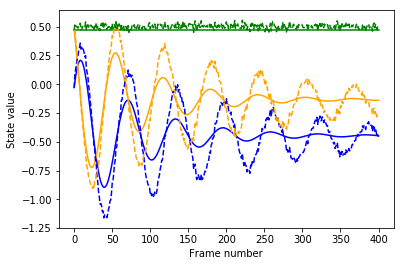

In [901]:
plt.plot(X[0,:].T, color='blue', linestyle='-')
plt.plot(X[1,:].T, color='orange', linestyle='-')
plt.plot(X[2,:].T, color='green', linestyle='-')

plt.plot(Xn[0,:].T, color='blue', linestyle='--')
plt.plot(Xn[1,:].T, color='orange', linestyle='--')
plt.plot(Xn[2,:].T, color='green', linestyle='--')

plt.xlabel('Frame number')
plt.ylabel('State value')

# Second informed reconstruction

Suppose we also know that A[1,0] and A[0,1] are equal but opposite sign, that is, A[0:2, 0:2].

In [902]:
# Set up the variables
A = cvxpy.Variable((X.shape[0], X.shape[0]))

# Define the objective function
L1 = cvxpy.sum_squares(X2 - (A@X1)) # X2 = A X1, this constraint is "the data"
obj = cvxpy.Minimize(L1) 

In [903]:
A_known = np.matrix([[np.nan, np.nan, np.nan],
                     [np.nan, np.nan, np.nan],
                     [0, 0, 1]])

epsilon = 1e-8
constraints = []
# constraints
if A_known is not None:
    for i in range(A_known.shape[0]):
        for j in range(A_known.shape[1]):
            if not np.isnan(A_known[i,j]):
                constraint_lo = A[i,j] >= A_known[i,j]-epsilon
                constraint_hi = A[i,j] <= A_known[i,j]+epsilon 
                constraints.extend([constraint_lo, constraint_hi])
                
constraint_lo = A[0,1] + A[1,0] <= epsilon
constraint_hi = A[0,1] + A[1,0] >= -epsilon
constraints.extend([constraint_lo, constraint_hi])


# Solve the problem
prob = cvxpy.Problem(obj, constraints)
prob.solve(solver='MOSEK') 

A_cvx_inf2 = np.matrix(A.value)
A_cvx_inf2

matrix([[ 9.91865318e-01,  1.00328875e-01,  2.10286195e-02],
        [-1.00328887e-01,  9.75196904e-01, -1.02683597e-01],
        [-5.02213422e-10, -9.08541216e-09,  9.99999983e-01]])

In [904]:
X = X1[:,0]

iterations = 400
for i in range(iterations):
    xnew = A_cvx_inf2*X[:, -1]
    X = np.hstack((X, xnew))

Text(0,0.5,'State value')

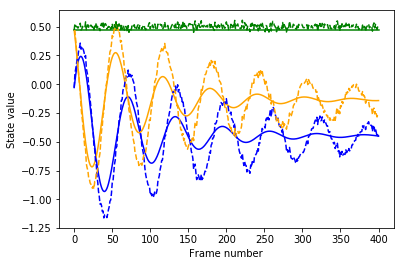

In [905]:
plt.plot(X[0,:].T, color='blue', linestyle='-')
plt.plot(X[1,:].T, color='orange', linestyle='-')
plt.plot(X[2,:].T, color='green', linestyle='-')

plt.plot(Xn[0,:].T, color='blue', linestyle='--')
plt.plot(Xn[1,:].T, color='orange', linestyle='--')
plt.plot(Xn[2,:].T, color='green', linestyle='--')

plt.xlabel('Frame number')
plt.ylabel('State value')

# Third informed reconstruction

Suppose we also know the system is very unstable. That means that for this discrete system the sum of the eigenvalues should be close to 3, since anything over three means that at least one eigenvalue is > 1, which for the discrete system is unstable.

The sum of the eigenvalues is equal to the trace of the matrix, so we can constrain the trace to be large. However, we cannot maximize the trace, because that is not convex. 

This is, kind of, cheating, because really we don't know the trace, but it is a demo that might be useful.

In [906]:
# Set up the variables
A = cvxpy.Variable((X.shape[0], X.shape[0]))

# Define the objective function
L1 = cvxpy.sum_squares(X2 - (A@X1)) # X2 = A X1, this constraint is "the data"
obj = cvxpy.Minimize(L1) 

In [907]:
A_known = np.matrix([[np.nan, np.nan, np.nan],
                     [np.nan, np.nan, np.nan],
                     [0, 0, 1]])

epsilon = 1e-8
constraints = []
# constraints
if A_known is not None:
    for i in range(A_known.shape[0]):
        for j in range(A_known.shape[1]):
            if not np.isnan(A_known[i,j]):
                constraint_lo = A[i,j] >= A_known[i,j]-epsilon
                constraint_hi = A[i,j] <= A_known[i,j]+epsilon 
                constraints.extend([constraint_lo, constraint_hi])
                
constraint_lo = A[0,1] + A[1,0] <= epsilon
constraint_hi = A[0,1] + A[1,0] >= -epsilon
constraints.extend([constraint_lo, constraint_hi])

# add the trace constraint
constraints.extend([cvxpy.trace(A)>=2.98])


# Solve the problem
prob = cvxpy.Problem(obj, constraints)
prob.solve(solver='MOSEK') 

A_cvx_inf3 = np.matrix(A.value)
A_cvx_inf3

matrix([[ 9.98088749e-01,  1.00310864e-01,  2.65885266e-02],
        [-1.00310869e-01,  9.81911244e-01, -1.00526127e-01],
        [-1.16797275e-09, -2.75280968e-09,  9.99999999e-01]])

In [908]:
X = X1[:,0]

iterations = 400
for i in range(iterations):
    xnew = A_cvx_inf3*X[:, -1]
    X = np.hstack((X, xnew))

Text(0,0.5,'State value')

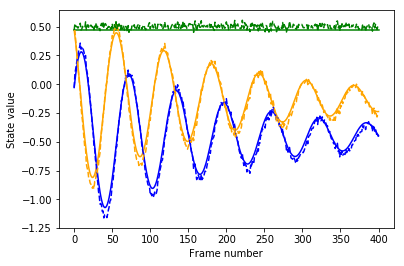

In [909]:
plt.plot(X[0,:].T, color='blue', linestyle='-')
plt.plot(X[1,:].T, color='orange', linestyle='-')
plt.plot(X[2,:].T, color='green', linestyle='-')

plt.plot(Xn[0,:].T, color='blue', linestyle='--')
plt.plot(Xn[1,:].T, color='orange', linestyle='--')
plt.plot(Xn[2,:].T, color='green', linestyle='--')

plt.xlabel('Frame number')
plt.ylabel('State value')

# Now let's explore non convex methods

These are more flexible, but slower.

Add `options={'maxiter': 10}` to keep the number of iterations small. 

# Multiple derivatives

While multiple derivatives are not convex, you can still optimize over them using general optimization routines. These may not be too slow if you use a convex result to seed the solution.

In [910]:
import scipy.optimize

In [911]:
Xn = X + np.matrix([np.random.normal(0, 0.02, iterations+1)]*3)

X1 = Xn[:,0:-6]
X2 = Xn[:,1:-5] 
X3 = Xn[:,2:-4] 
X4 = Xn[:,3:-3]
X5 = Xn[:,4:-2] 
X6 = Xn[:,5:-1] 

In [912]:
def loss(x):
    A = np.reshape(x,[3,3])
    L1 = np.linalg.norm((X2 - A@X1))
    L2 = np.linalg.norm((X3 - A@A@X1))
    L3 = np.linalg.norm((X4 - A@A@A@X1))
    L4 = np.linalg.norm((X5 - A@A@A@A@X1))
    L5 = np.linalg.norm((X6 - A@A@A@A@A@X1))
    
    return L1 + L2 + L3 + L4 + L5

In [913]:
val = scipy.optimize.minimize(loss, np.ravel(A_cvx_inf2), options={'maxiter': 50})
A_noncvx = np.matrix(np.reshape(val.x, [3,3]))
A_noncvx

matrix([[ 0.99434457,  0.09880226,  0.02169208],
        [-0.10098237,  0.98050277, -0.1009369 ],
        [-0.00268989, -0.00152447,  0.99665157]])

Text(0,0.5,'State value')

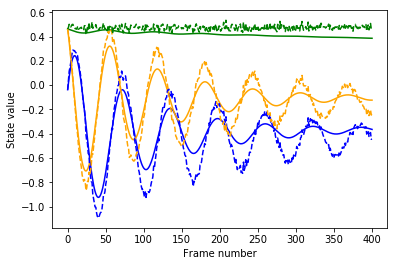

In [914]:
X = X1[:,0]

iterations = 400
for i in range(iterations):
    xnew = A_noncvx*X[:, -1]
    X = np.hstack((X, xnew))
    
plt.plot(X[0,:].T, color='blue', linestyle='-')
plt.plot(X[1,:].T, color='orange', linestyle='-')
plt.plot(X[2,:].T, color='green', linestyle='-')

plt.plot(Xn[0,:].T, color='blue', linestyle='--')
plt.plot(Xn[1,:].T, color='orange', linestyle='--')
plt.plot(Xn[2,:].T, color='green', linestyle='--')

plt.xlabel('Frame number')
plt.ylabel('State value')

# Known eigenvalues

Suppose we knew the N largest eigenvalues. It seems that CVX won't let us use that as a constraint. We can use it with traditional optimization, however. 

Here we use the guess from the convex optimization to seed the traditional optimization.

For demo purposes, we assume that the exact 2 largest eigenvalues are known (cheating).

In [915]:
def get_sorted_pos_eigenvalues_for_matrix(A):
    eigs = np.linalg.eigvals(A)
    eigs_pos_imag = []
    for ix, eig in enumerate(eigs):
        if eig.imag >= 0:
            eigs_pos_imag.append(eigs[ix])
    eigs_pos_imag = np.array(eigs_pos_imag)
    eigs_pos_imag_sorted = eigs_pos_imag[np.argsort(eigs_pos_imag)]
    return eigs_pos_imag_sorted

In [916]:
def loss(x):
    A = np.reshape(x,[3,3])
    L1 = np.linalg.norm((X2 - A@X1))
    
    L6 = np.linalg.norm(get_sorted_pos_eigenvalues_for_matrix(A)[0:2] - get_sorted_pos_eigenvalues_for_matrix(Atrue)[0:2])
    
    return L1 + 100*L6 # make the eigenvalues 100x more important than matching the data


In [917]:
val = scipy.optimize.minimize(loss, np.ravel(A_cvx_inf2), options={'maxiter': 50})
A_noncvx = np.matrix(np.reshape(val.x, [3,3]))
A_noncvx

matrix([[ 0.99417095,  0.09783388,  0.0140674 ],
        [-0.10098302,  0.98157164, -0.10386846],
        [ 0.00395484,  0.00165484,  1.00425741]])

Text(0,0.5,'State value')

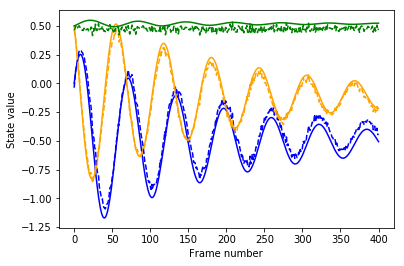

In [918]:
X = Xtrue[:,0]

iterations = 400
for i in range(iterations):
    xnew = A_noncvx*X[:, -1]
    X = np.hstack((X, xnew))
    
plt.plot(X[0,:].T, color='blue', linestyle='-')
plt.plot(X[1,:].T, color='orange', linestyle='-')
plt.plot(X[2,:].T, color='green', linestyle='-')

plt.plot(Xn[0,:].T, color='blue', linestyle='--')
plt.plot(Xn[1,:].T, color='orange', linestyle='--')
plt.plot(Xn[2,:].T, color='green', linestyle='--')

plt.xlabel('Frame number')
plt.ylabel('State value')

# Alternate between CVX and Traditional optimization

In principle you could alternate between the two approaches, perhaps that helps for larger problems.

In [919]:
def cvx_opt(X1, X2, A_known=None):
    if A_known is None:
        A_known = np.matrix([[np.nan, np.nan, np.nan],
                             [np.nan, np.nan, np.nan],
                             [0, 0, 1]])

    # Set up the variables
    A = cvxpy.Variable((X.shape[0], X.shape[0]))

    # Define the objective function
    L1 = cvxpy.sum_squares(X2 - (A@X1)) # X2 = A X1, this constraint is "the data"
    obj = cvxpy.Minimize(L1) 
    
    epsilon = 1e-2 # largish epsilon, allows some drift away from A_known
    constraints = []
    # constraints
    if A_known is not None:
        for i in range(A_known.shape[0]):
            for j in range(A_known.shape[1]):
                if not np.isnan(A_known[i,j]):
                    constraint_lo = A[i,j] >= A_known[i,j]-epsilon
                    constraint_hi = A[i,j] <= A_known[i,j]+epsilon 
                    constraints.extend([constraint_lo, constraint_hi])

    # Solve the problem
    prob = cvxpy.Problem(obj, constraints)
    prob.solve(solver='MOSEK') 

    A_cvx_inf2 = np.matrix(A.value)
    return A_cvx_inf2

In [920]:
def trad_opt(X1, X2, A_cvx, Atrue):
    def loss(x):
        A = np.reshape(x,[3,3])
        L1 = np.linalg.norm((X2 - A@X1))
        L6 = np.linalg.norm(get_sorted_pos_eigenvalues_for_matrix(A)[0:2] - get_sorted_pos_eigenvalues_for_matrix(Atrue)[0:2])
        return L1 + 100*L6 # make the eigenvalues 100x more important than matching the data
    
    val = scipy.optimize.minimize(loss, np.ravel(A_cvx_inf2), options={'maxiter': 50})
    A_noncvx = np.matrix(np.reshape(val.x, [3,3]))
    return A_noncvx

Text(0,0.5,'State value')

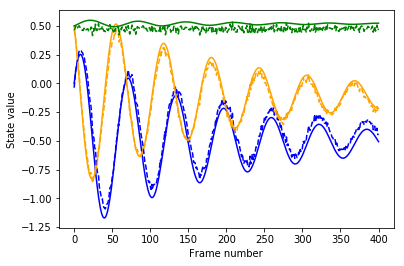

In [921]:
# iteration 1
A_cvx = cvx_opt(X1, X2, A_known=None)
A_noncvx = trad_opt(X1, X2, A_cvx, Atrue)

# reconstruct
X = Xtrue[:,0]

iterations = 400
for i in range(iterations):
    xnew = A_noncvx*X[:, -1]
    X = np.hstack((X, xnew))
    
plt.plot(X[0,:].T, color='blue', linestyle='-')
plt.plot(X[1,:].T, color='orange', linestyle='-')
plt.plot(X[2,:].T, color='green', linestyle='-')

plt.plot(Xn[0,:].T, color='blue', linestyle='--')
plt.plot(Xn[1,:].T, color='orange', linestyle='--')
plt.plot(Xn[2,:].T, color='green', linestyle='--')

plt.xlabel('Frame number')
plt.ylabel('State value')

Text(0,0.5,'State value')

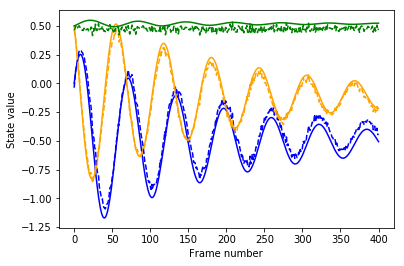

In [922]:
# iteration 2
A_cvx = cvx_opt(X1, X2, A_known=A_noncvx) # note difference
A_noncvx = trad_opt(X1, X2, A_cvx, Atrue)

# reconstruct
X = Xtrue[:,0]

iterations = 400
for i in range(iterations):
    xnew = A_noncvx*X[:, -1]
    X = np.hstack((X, xnew))
    
plt.plot(X[0,:].T, color='blue', linestyle='-')
plt.plot(X[1,:].T, color='orange', linestyle='-')
plt.plot(X[2,:].T, color='green', linestyle='-')

plt.plot(Xn[0,:].T, color='blue', linestyle='--')
plt.plot(Xn[1,:].T, color='orange', linestyle='--')
plt.plot(Xn[2,:].T, color='green', linestyle='--')

plt.xlabel('Frame number')
plt.ylabel('State value')

Text(0,0.5,'State value')

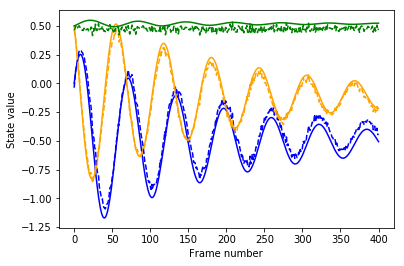

In [923]:
# iteration 3
A_cvx = cvx_opt(X1, X2, A_known=A_noncvx) # note difference
A_noncvx = trad_opt(X1, X2, A_cvx, Atrue)

# reconstruct
X = Xtrue[:,0]

iterations = 400
for i in range(iterations):
    xnew = A_noncvx*X[:, -1]
    X = np.hstack((X, xnew))
    
plt.plot(X[0,:].T, color='blue', linestyle='-')
plt.plot(X[1,:].T, color='orange', linestyle='-')
plt.plot(X[2,:].T, color='green', linestyle='-')

plt.plot(Xn[0,:].T, color='blue', linestyle='--')
plt.plot(Xn[1,:].T, color='orange', linestyle='--')
plt.plot(Xn[2,:].T, color='green', linestyle='--')

plt.xlabel('Frame number')
plt.ylabel('State value')